<a href="https://colab.research.google.com/github/lhayana/flight-price-prediction/blob/main/Flight_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fonte dos dados: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

# Importando os dados e as bibliotecas

In [ ]:
  # pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
# pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from category_encoders import TargetEncoder, CatBoostEncoder
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import RFE

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!wget https://raw.githubusercontent.com/lhayana/flight-price-prediction/refs/heads/main/data/Clean_Dataset.csv

--2024-10-30 13:45:34--  https://raw.githubusercontent.com/lhayana/flight-price-prediction/refs/heads/main/data/Clean_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24683279 (24M) [text/plain]
Saving to: ‘Clean_Dataset.csv’

Clean_Dataset.csv   100%[===================>]  23.54M   115MB/s    in 0.2s    

2024-10-30 13:45:34 (115 MB/s) - ‘Clean_Dataset.csv’ saved [24683279/24683279]



In [ ]:
data = pd.read_csv('Clean_Dataset.csv', index_col=0)

In [ ]:
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
data['route'] = data['source_city'] + ' - ' + data['destination_city']

# Análise exploratória

In [ ]:
sns.set(style="whitegrid")

<ipython-input-12-09caffa5c07a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='airline', data=data, order=airline_order, palette='hls')


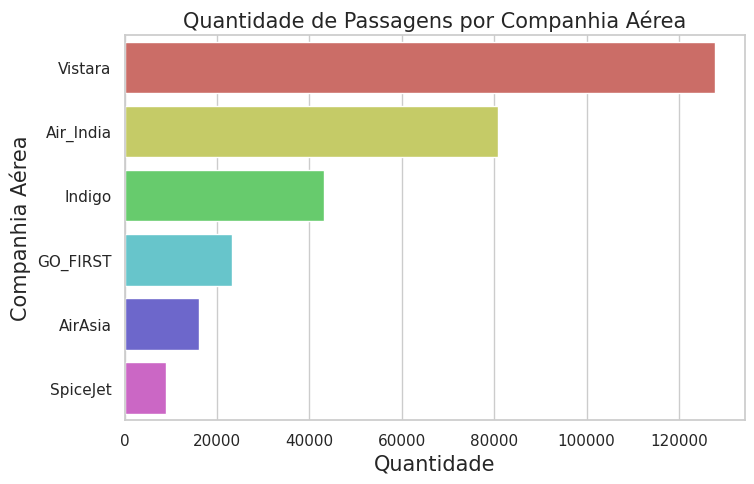

In [ ]:
plt.figure(figsize=(8,5))
airline_order = data['airline'].value_counts().index
sns.countplot(y='airline', data=data, order=airline_order, palette='hls')
plt.title('Quantidade de Passagens por Companhia Aérea', fontsize=15)
plt.xlabel('Quantidade', fontsize=15)
plt.ylabel('Companhia Aérea', fontsize=15)
plt.show()

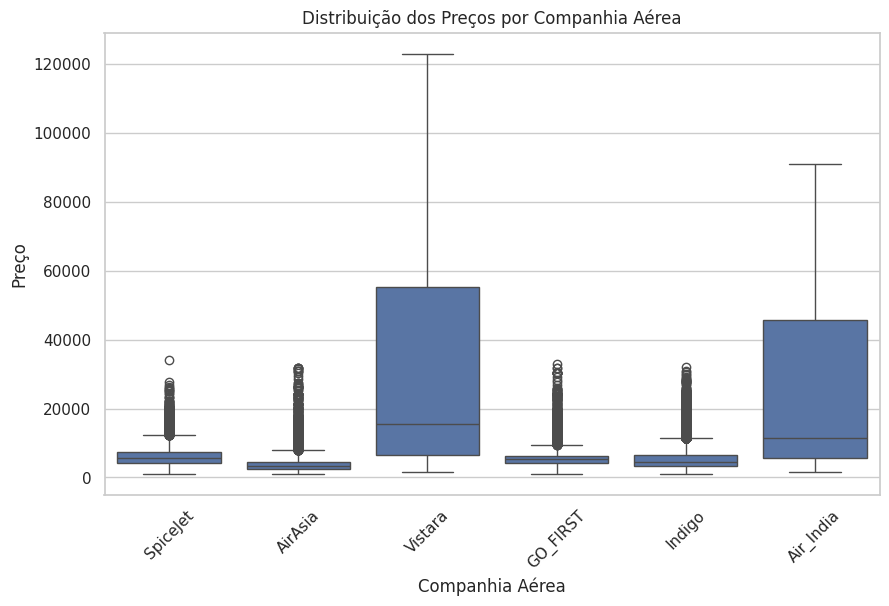

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='airline', y='price', data=data)
plt.title('Distribuição dos Preços por Companhia Aérea')
plt.xlabel('Companhia Aérea')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

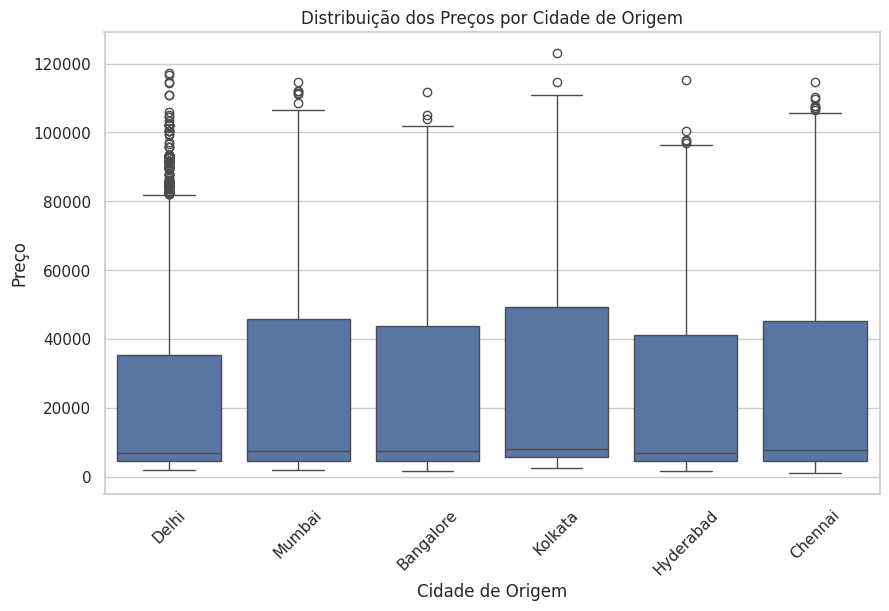

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='source_city', y='price', data=data)
plt.title('Distribuição dos Preços por Cidade de Origem')
plt.xlabel('Cidade de Origem')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

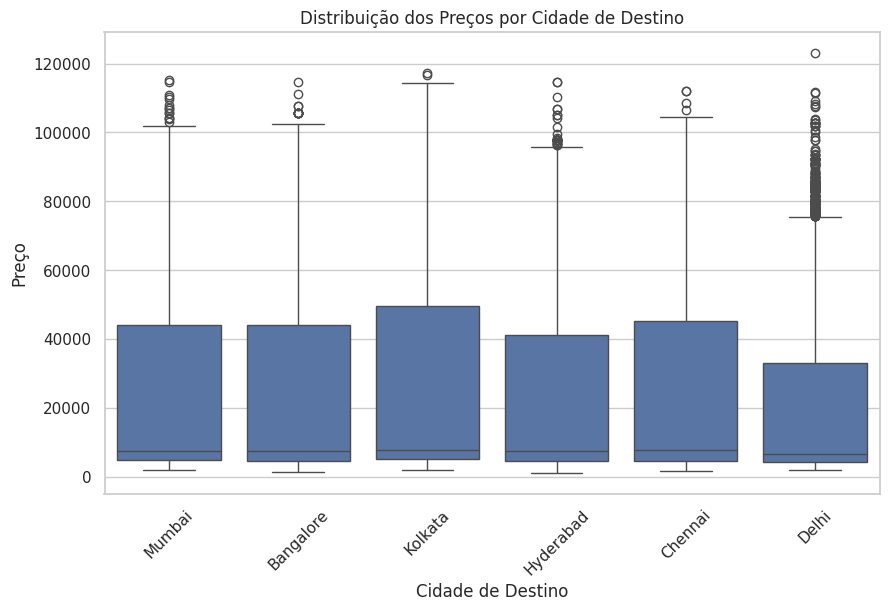

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='destination_city', y='price', data=data)
plt.title('Distribuição dos Preços por Cidade de Destino')
plt.xlabel('Cidade de Destino')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

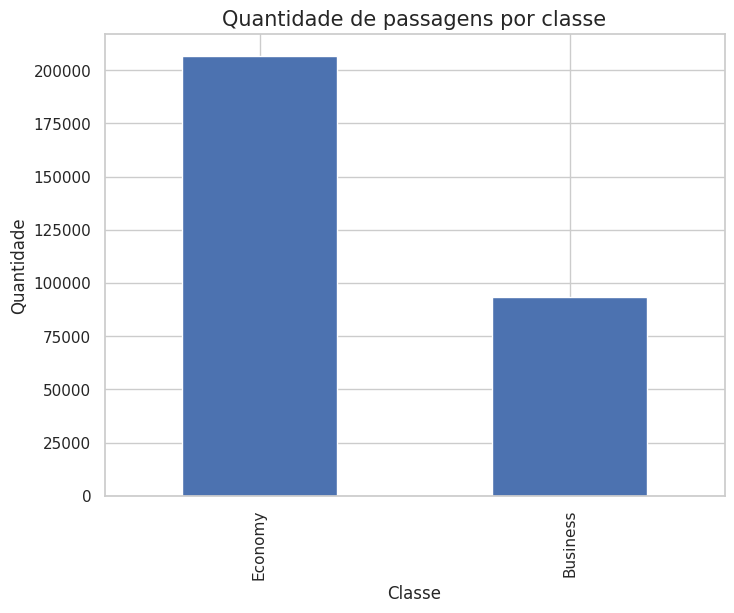

In [ ]:
plt.figure(figsize=(8,6))
class_counts = data['class'].value_counts()
class_counts.plot(kind='bar')
plt.title('Quantidade de passagens por classe', fontsize=15)
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(ticks=range(len(class_counts)), labels=class_counts.index)
plt.show()

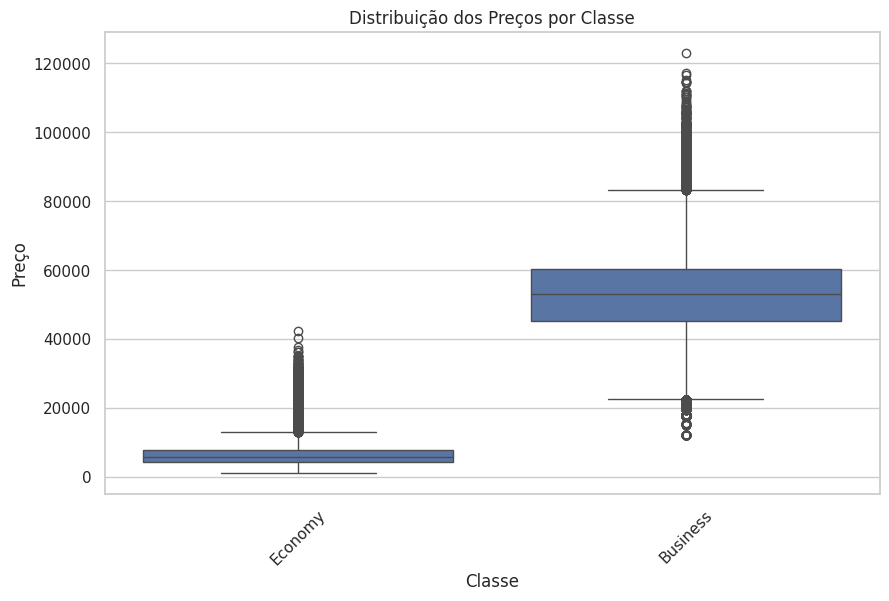

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='price', data=data)
plt.title('Distribuição dos Preços por Classe')
plt.xlabel('Classe')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

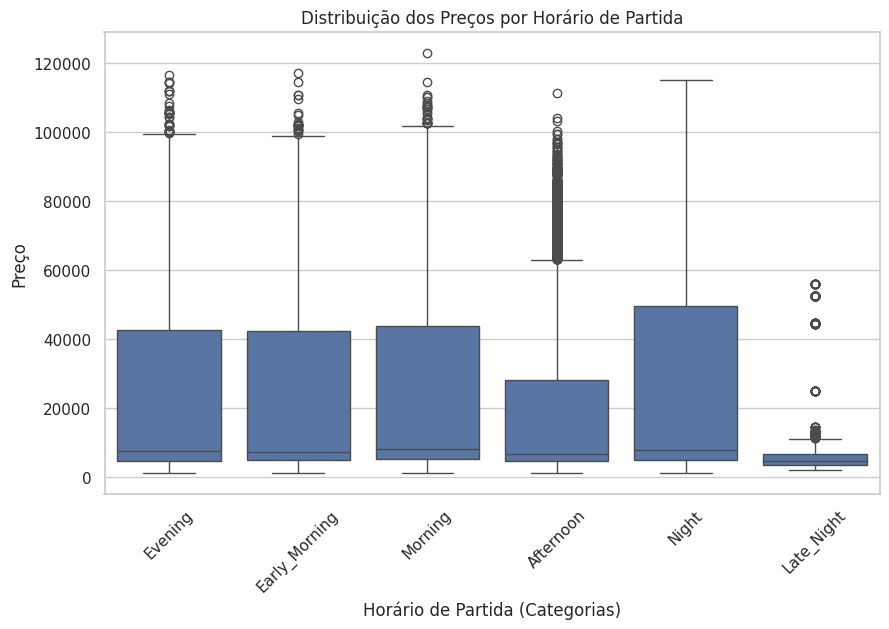

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='departure_time', y='price', data=data)
plt.title('Distribuição dos Preços por Horário de Partida')
plt.xlabel('Horário de Partida (Categorias)')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

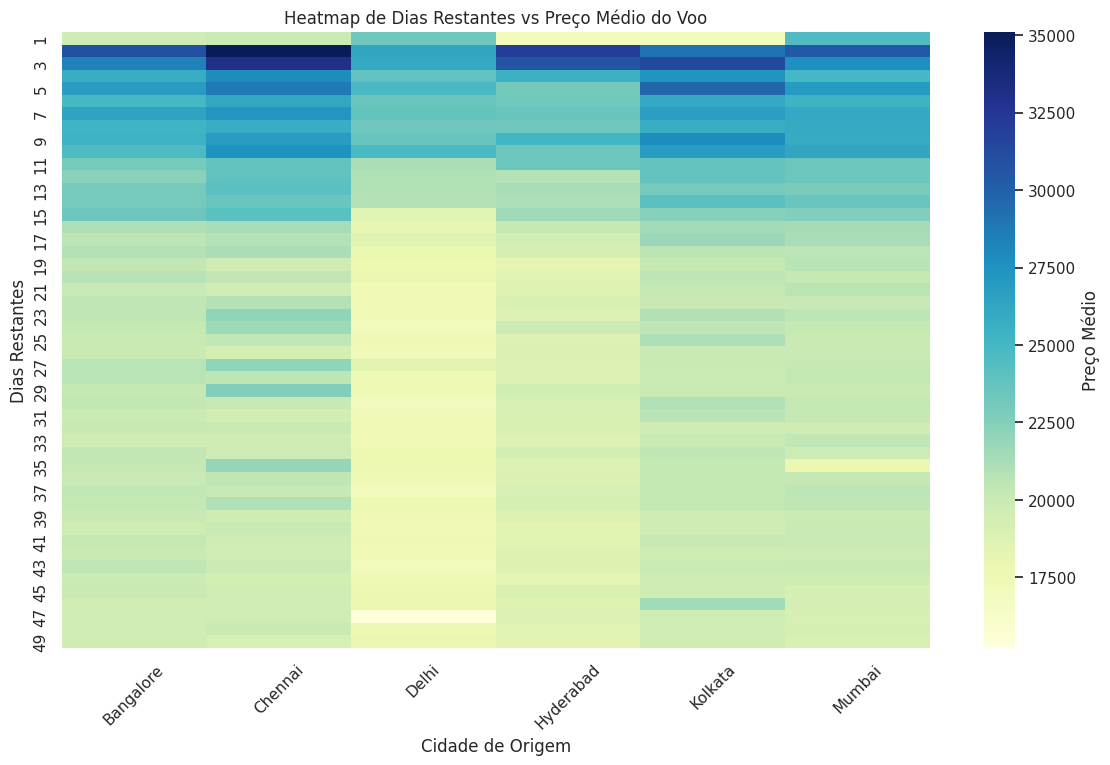

In [ ]:
heatmap_dias = pd.pivot_table(data, values='price', index='days_left', columns='source_city', aggfunc='mean')

# Plotando o heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_dias, cmap='YlGnBu', cbar_kws={'label': 'Preço Médio'})
plt.title('Heatmap de Dias Restantes vs Preço Médio do Voo')
plt.xlabel('Cidade de Origem')
plt.ylabel('Dias Restantes')
plt.xticks(rotation=45)
plt.show()

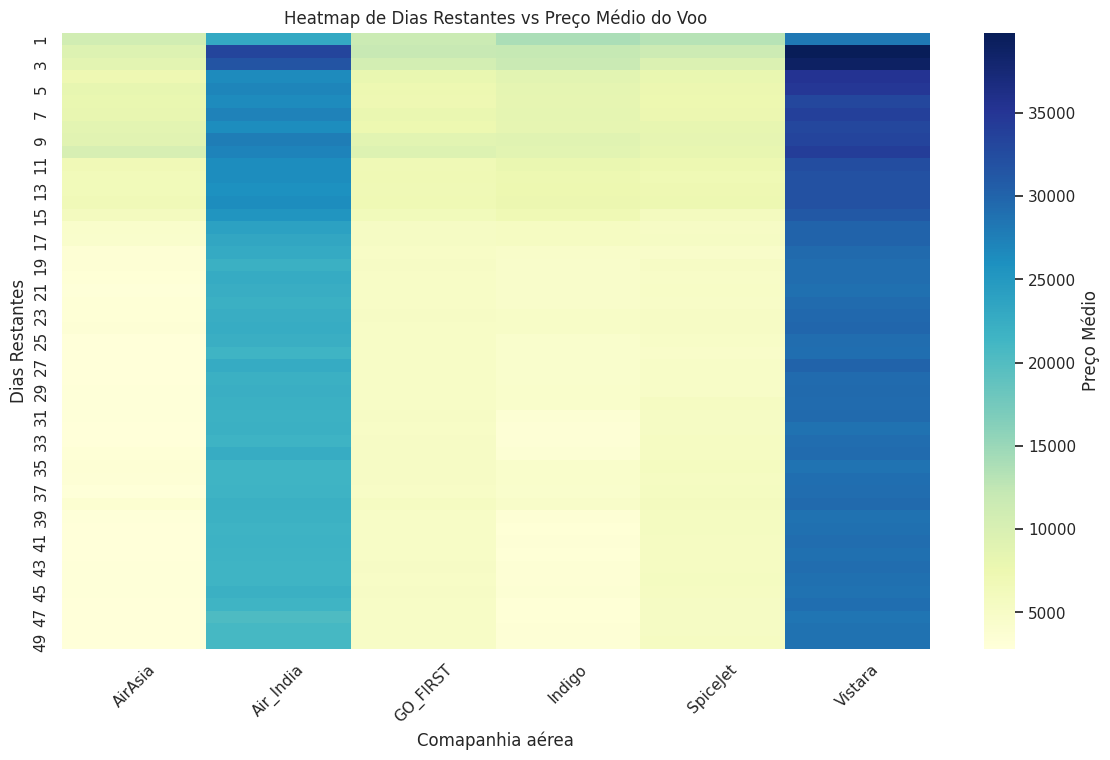

In [ ]:
heatmap_dias = pd.pivot_table(data, values='price', index='days_left', columns='airline', aggfunc='mean')

# Plotando o heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_dias, cmap='YlGnBu', cbar_kws={'label': 'Preço Médio'})
plt.title('Heatmap de Dias Restantes vs Preço Médio do Voo')
plt.xlabel('Comapanhia aérea')
plt.ylabel('Dias Restantes')
plt.xticks(rotation=45)
plt.show()

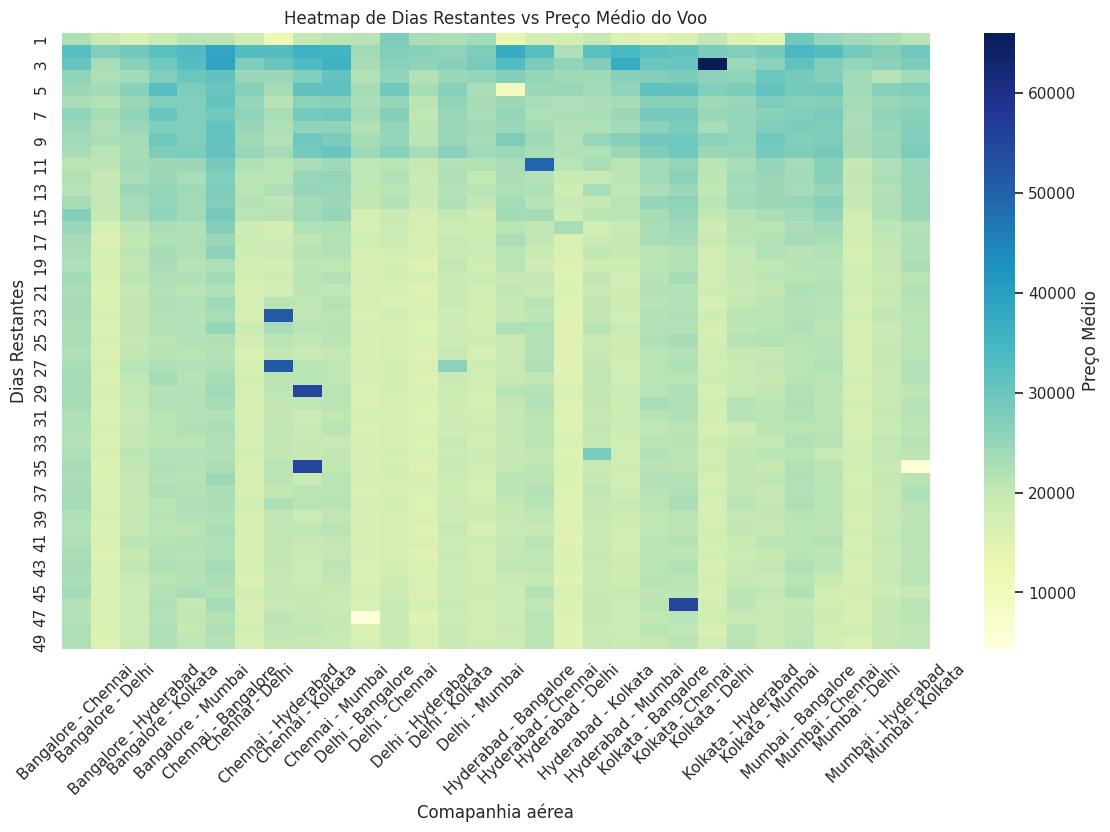

In [ ]:
heatmap_dias = pd.pivot_table(data, values='price', index='days_left', columns='route', aggfunc='mean')

# Plotando o heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_dias, cmap='YlGnBu', cbar_kws={'label': 'Preço Médio'})
plt.title('Heatmap de Dias Restantes vs Preço Médio do Voo')
plt.xlabel('Comapanhia aérea')
plt.ylabel('Dias Restantes')
plt.xticks(rotation=45)
plt.show()

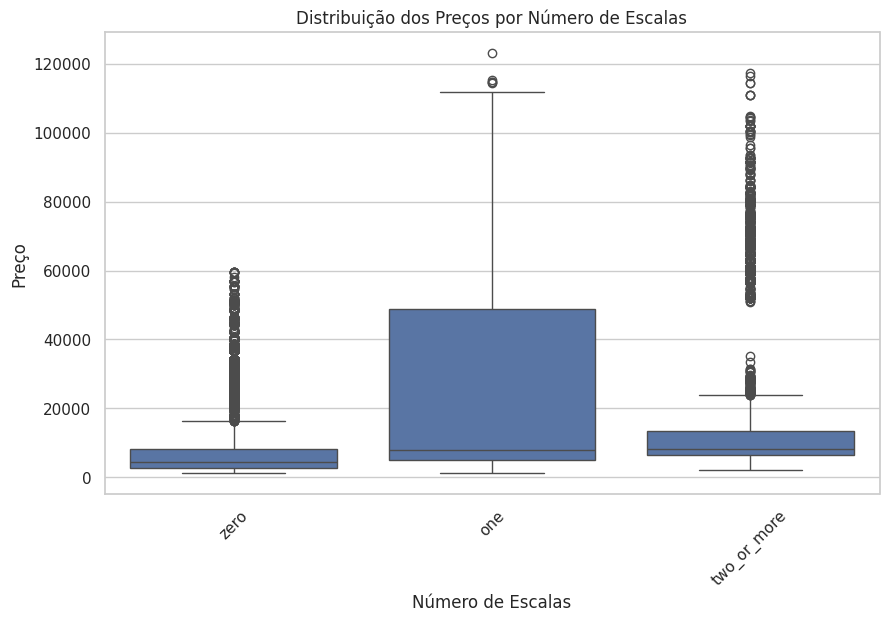

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='stops', y='price', data=data)
plt.title('Distribuição dos Preços por Número de Escalas')
plt.xlabel('Número de Escalas')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

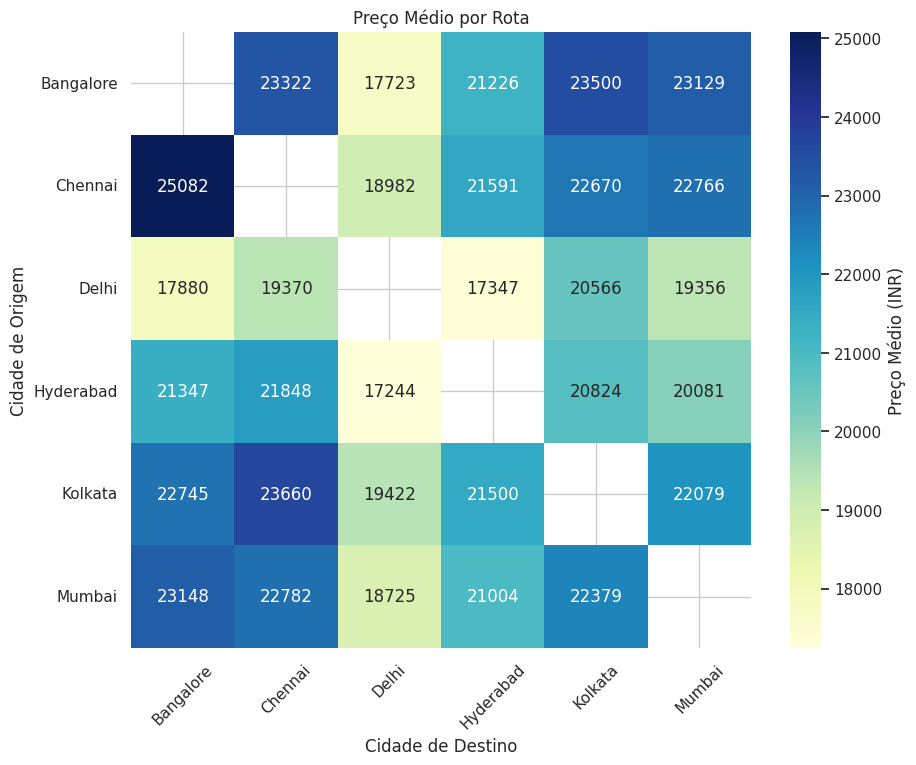

In [ ]:
heatmap_data = data.pivot_table(values='price',
                                index='source_city',
                                columns='destination_city',
                                aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Preço Médio (INR)'})
plt.title('Preço Médio por Rota')
plt.xlabel('Cidade de Destino')
plt.ylabel('Cidade de Origem')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Modelagem

In [ ]:
data.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price', 'route'],
      dtype='object')

In [ ]:
numerical_features= ['duration','days_left']

categorical_features = ['airline', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'route']

In [ ]:
features = ['airline', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'route'] # todas as variáveis, menos o código do vôo

target = 'price'

In [ ]:
X = data[features]
y = data[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("encoder", TargetEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

#### Testando diversos modelos

In [ ]:
xgb = XGBRegressor()

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',xgb)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'days_left']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city', 'class',
                                                   'route'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=Non...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

MAE: 1953.2222602723375
MSE: 12105186.61054594
RMSE: 3479.250869159328
MAPE: 0.14299832252169142


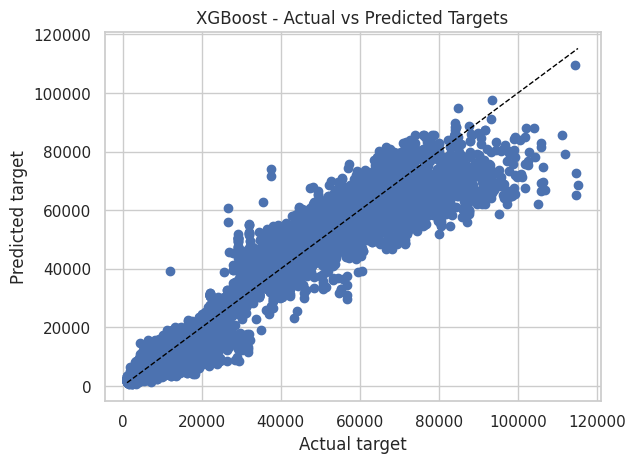

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('XGBoost - Actual vs Predicted Targets')
plt.show()

In [ ]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores

array([-11686956.14785645, -11719370.53597352, -11948979.83081784,
       -12180957.41973238, -11546208.04672671])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 10
[LightGBM] [Info] Start training from score 20888.572417
MAE: 2277.134045115913
MSE: 15298417.118536497
RMSE: 3911.319102110757
MAPE: 0.1705716757055213


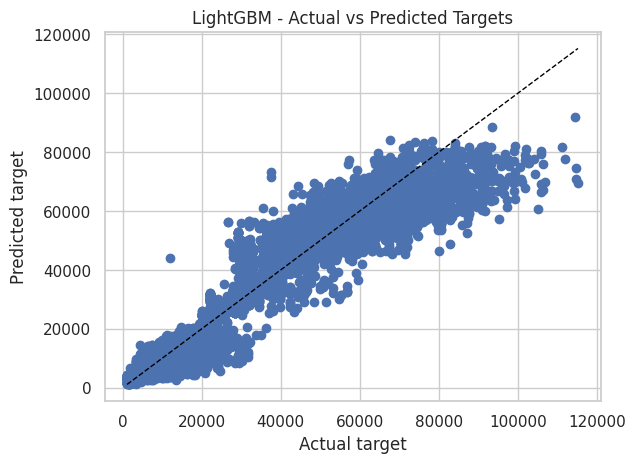

In [ ]:
# LightGBM

from lightgbm import LGBMRegressor
lgb = LGBMRegressor()
pipe_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb)
])
pipe_lgb.fit(X_train, y_train)

y_pred = pipe_lgb.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

y_test.mean()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('LightGBM - Actual vs Predicted Targets')
plt.show()

MAE: 2028.3191230805903
MSE: 12862977.201426007
RMSE: 3586.4992961697353
MAPE: 0.1459687597376007


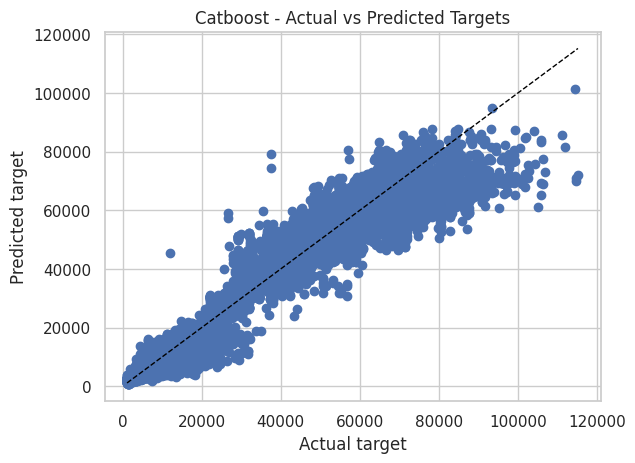

In [ ]:
# Catboost

cat = CatBoostRegressor(silent=True)
pipe_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', cat)
])
pipe_cat.fit(X_train, y_train)

y_pred = pipe_cat.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

y_test.mean()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('Catboost - Actual vs Predicted Targets')
plt.show()

MAE: 4549.368962741366
MSE: 45263745.25979625
RMSE: 6727.833623076321
MAPE: 0.4680377595829953


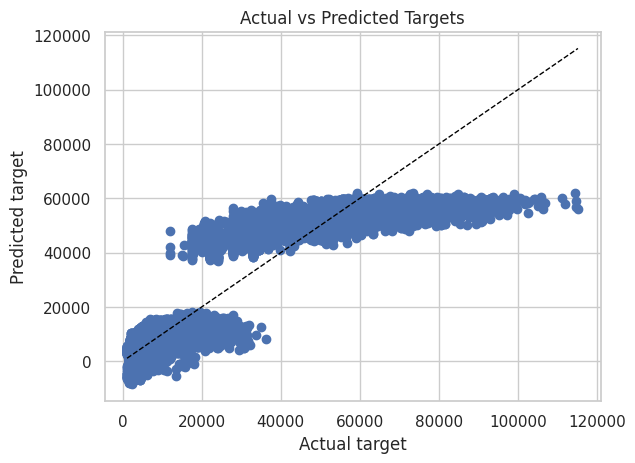

In [ ]:
# Regressão Ridge

from sklearn.linear_model import Ridge
ridge = Ridge()

categorical_transformer_ridge = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]) # encoder diferente

preprocessor_ridge = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ("cat", categorical_transformer_ridge, categorical_features)
])

pipe_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor_ridge),
    ('model', ridge)
])

pipe_ridge.fit(X_train, y_train)

y_pred = pipe_ridge.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

y_test.mean()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('Actual vs Predicted Targets')
plt.show()

#### Resultados com cross-validation

In [ ]:
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

mape_scorer = make_scorer(mape, greater_is_better=False)

def evaluate_model(pipe, X, y):
    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring=mape_scorer)
    return cv_scores.mean(), cv_scores.std()

results = {}

results['XGBoost'] = evaluate_model(pipe, X_train, y_train)
results['LightGBM'] = evaluate_model(pipe_lgb, X_train, y_train)
results['CatBoost'] = evaluate_model(pipe_cat, X_train, y_train)
results['Ridge'] = evaluate_model(pipe_ridge, X_train, y_train)

results_df = pd.DataFrame(results, index=['Mean MAPE', 'Std MAPE']).T
print("\nResultados dos Modelos:")
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 192097, number of used features: 10
[LightGBM] [Info] Start training from score 20892.155041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 192097, number of used features: 10
[LightGBM] [Info] Start training from score 20873.140413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

# Feature importance

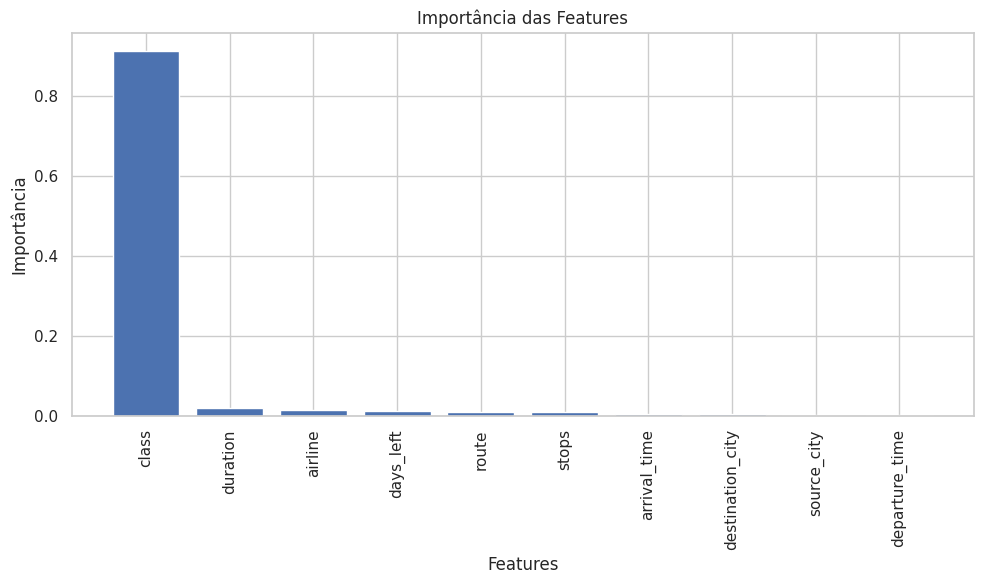

In [ ]:
importances = pipe.named_steps['model'].feature_importances_

feature_names = np.concatenate((numerical_features, categorical_features))

plt.figure(figsize=(10, 6))
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title('Importância das Features')
plt.xlabel('Features')
plt.ylabel('Importância')
plt.tight_layout()
plt.show()

MAE: 2591.1207766937605
MSE: 19736882.088324055


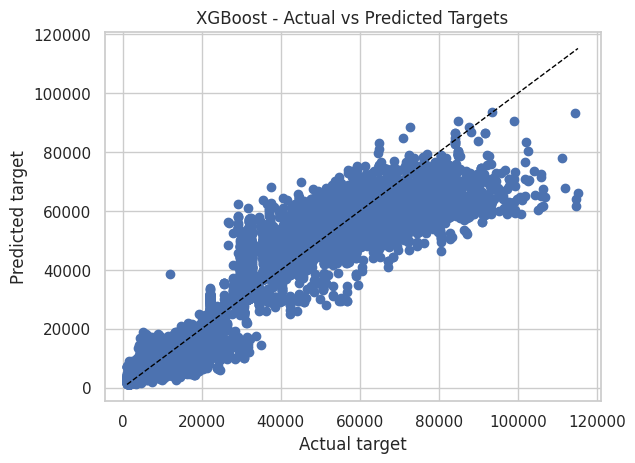

In [ ]:
# @title
selected_numerical_features= ['days_left']

selected_categorical_features = ['class', 'duration', 'route', 'stops']

selected_features = ['class', 'duration', 'route', 'days_left', 'stops']

target = 'price'

X = data[selected_features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("encoder", TargetEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, selected_numerical_features),
    ("cat", categorical_transformer, selected_categorical_features)
])
xgb = XGBRegressor()

selected_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',xgb)
])

selected_pipe.fit(X_train, y_train)
y_pred = selected_pipe.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('XGBoost - Actual vs Predicted Targets')
plt.show()

In [ ]:
# @title
results['XGBoost_Selected'] = evaluate_model(selected_pipe, X_train, y_train)

results_df = pd.DataFrame(results, index=['Mean RMSE', 'Std RMSE']).T
print("\nResultados dos Modelos:")
print(results_df)


Resultados dos Modelos:
                    Mean RMSE   Std RMSE
XGBoost           3437.359861  32.428070
LightGBM          3871.530384  32.781951
CatBoost          3561.203536  29.386289
Ridge             7101.063653  30.656847
XGBoost_Selected  4418.314855  23.470134
